<a href="https://colab.research.google.com/github/DOspinalUN23/MetNumUN2024II/blob/main/LabATQ/diospinalLabATQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB ATQ – Algorithmic Trading with Quantiacs

En el laboratorio se utilizó modelos de Machine Learning para predecir el precio de ciertas acciones dentro del S&P 500, y de acuerdo a eso comprar, vender, o no hacer nada

## Modificaciones
1. The Machine Learning technique: \
Se cambio de Linear Regression a Gradient Boosting Regressor.

In [ ]:
def get_model():
    """Constructor del modelo de Gradient Boosting"""
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    return model

2. The market and assets: \
Se cambio de NASDAQ a S&P 500 y se incluyeron 37 assets.



In [ ]:
# loading S&P 500 stock data
assets=[
    'NAS:ACGL', 'NAS:ADBE', 'NAS:ADI', 'NAS:ADP', 'NAS:ADSK', 'NAS:AMAT', 'NAS:AMD',
    'NAS:AMGN', 'NAS:AMZN', 'NAS:ANSS', 'NAS:AAPL', 'NAS:AVGO', 'NAS:BKR', 'NAS:BKNG',
    'NAS:CERN', 'NAS:COST', 'NAS:DTV', 'NAS:FOX', 'NAS:GOOG', 'NAS:GOOGL', 'NAS:JAVA',
    'NAS:LOGI', 'NAS:MELI', 'NAS:NFLX', 'NAS:QCOM', 'NAS:TEAM', 'NAS:TMUS', 'NAS:TSLA',
    'NAS:UAL', 'NYS:BSX', 'NYS:BWA', 'NYS:BX', 'NYS:DELL', 'NYS:MET', 'NYS:MGM', 'NYS:UBER',
    'NYS:UDR'
]

stock_data = qndata.stocks.load_spx_data(tail = 365 * 5, assets = assets)

3. The variables: \
Se incluyeron las variables OBV (On-Balance Volume) y EMA (Exponential Moving Average).



In [ ]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    # trend = trend.assign_coords(field="trend")

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
    # macd2_signal = macd2_signal.assign_coords(field="macd")

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)
    # volatility = volatility.assign_coords(field="volatility")

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    # d = d.assign_coords(field="stochastic_d")

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))
    # rsi = rsi.assign_coords(field="rsi")

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)
    # price = price.assign_coords(field="price")

    ## New features ##
    ema = qnta.ema(data.sel(field="close"), 20)
    # ema = ema.assign_coords(field="ema")

    obv = qnta.obv(data.sel(field="close"), data.sel(field="vol"))
    # obv = obv.assign_coords(field="obv")

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal.sel(field="close"), volatility,  d, rsi, price, obv, ema],
        pd.Index(
            ["trend",  "macd", "volatility", "stochastic_d", "rsi", "price", "obv", "ema"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

4. The targets: \
Se modifico para que ahora también venda acciones, cuando el precio sube un 11% se compra, cuando baja un 11% vende, y cuando el cambio no es mayor a un 11%, no se vende ni se compra


In [ ]:
def get_target_classes(data):
    """Clases objetivo para predecir si el precio sube, baja o se mantiene dentro de un rango de 5%"""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    # Calculamos el cambio porcentual en el precio
    change = (price_future - price_current) / price_current

    class_positive = 1  # Subida
    class_neutral = 0   # No hay cambio significativo (subida o bajada)
    class_negative = -1 # Bajada

    # Creamos la variable objetivo
    target_price = xr.where(change > 0.11, class_positive, xr.where(change < -0.11, class_negative, class_neutral))

    return target_price

5. Liquid assets: \
Se realizo una verificación para que utilice solo assets liquidos

In [ ]:
is_liquid = stock_data.sel(field="is_liquid")
weights = weights * is_liquid
weights = qnout.clean(weights, stock_data, "stocks_s&p500")

## Resultado
Con estas modificaciones, se obtuvo el siguiente resultado

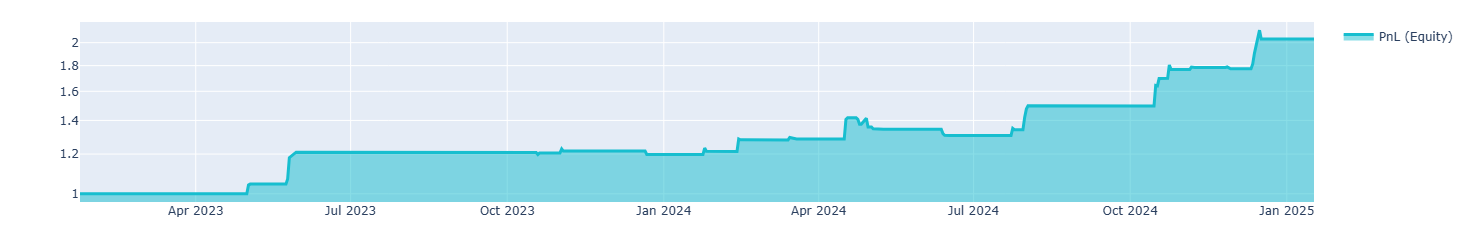

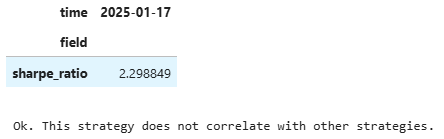

## Only Sell

In [ ]:
def get_target_classes(data):
    """Clases objetivo para predecir si el precio sube, baja o se mantiene dentro de un rango de 5%"""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    # Calculamos el cambio porcentual en el precio
    change = (price_future - price_current) / price_current

    # class_positive = 1  # Subida
    class_neutral = 0   # No hay cambio significativo (subida o bajada)
    class_negative = -1 # Bajada

    # Creamos la variable objetivo
    target_price = xr.where(change < -0.135, class_negative, class_neutral)

    return target_price

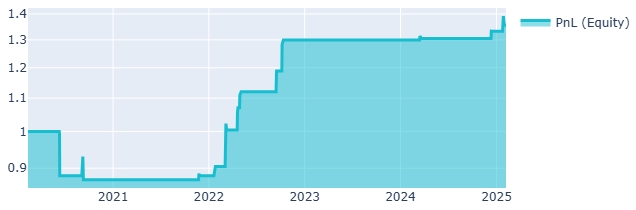

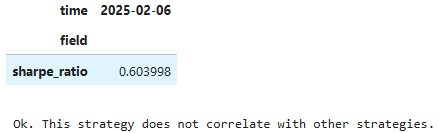

## Only Buy

In [ ]:
def get_target_classes(data):
    """Clases objetivo para predecir si el precio sube, baja o se mantiene dentro de un rango de 5%"""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    # Calculamos el cambio porcentual en el precio
    change = (price_future - price_current) / price_current

    class_positive = 1  # Subida
    class_neutral = 0   # No hay cambio significativo (subida o bajada)
    # class_negative = -1 # Bajada

    # Creamos la variable objetivo
    target_price = xr.where(change > 0.135, class_positive, class_neutral)

    return target_price

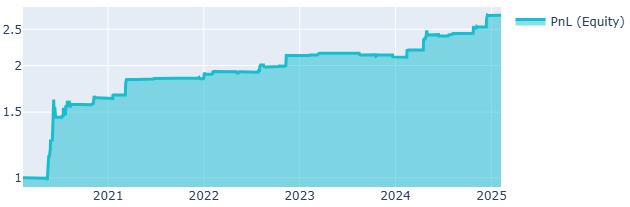

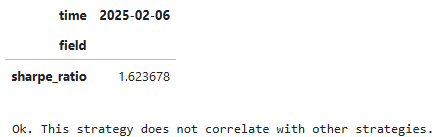